## MRS data를 plot으로 뿌려보기

- chr1_786070     other   [596, 7, 626, 9, 596, 11]    으로 되어 있어서 bracket 빼고 다시 구성해야 한다
- inputdf : 30:26:4	42:32:10


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

print ("Hi")

Hi


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import re
from mpl_toolkits import mplot3d

%matplotlib inline
colorlist = ['r', '#AFAFAF', 'g', '#9DC3E6', 'purple', "gray", "yellow", "black", "8c74c0", "ce9178"]
samplename_dict = {}

NUM_BLOCK_INPUT=3
NUM_BLOCK = 2
RANDOM_PICK = 1000
FP_RATIO = 0.17

#INPUT_DIR = "/data/project/Alzheimer/EM_cluster/MRS_data/EM_input/"
INPUT_DIR = "/data/project/Alzheimer/EM_cluster/pilot/04.EM_input/"
OUTPUT_DIR ="./output/"

input_containpos = pd.read_csv(INPUT_DIR + "M3_MT_MT2_all_input.txt",  header = None, names =["pos", "sample", "info"], sep = "\t") 


def makedf (input_containpos):
    global NUM_MUTATION; global depth_list
    NUM_MUTATION = input_containpos.shape[0]

    np_vaf = np.zeros((NUM_MUTATION, NUM_BLOCK_INPUT), dtype = 'float')
    inputdf = pd.DataFrame (np.zeros((NUM_MUTATION, NUM_BLOCK_INPUT), dtype = 'object'), columns = ['block' + str(i + 1) for i in range(NUM_BLOCK_INPUT)])
    mutation_id = []
    membership = []
    depth_list = []
    

    for row in range(NUM_MUTATION):
        mutation_id.append( str(input_containpos.iloc[row][0]) )
        membership.append( str(input_containpos.iloc[row][1]) )
        if str(input_containpos.iloc[row][1]) not in samplename_dict.keys():
            samplename_dict[str(input_containpos.iloc[row][1])] = int (len(samplename_dict))      # {'other': 0, 'V5': 1, 'V3': 2, 'V1': 3}

        rmv_bracket = re.sub("[\[\] ]", '', str(input_containpos.iloc[row][2])).split(",")
        depth_row=[]
        for i in range(0, len(rmv_bracket), 2 ):
            depth = int(rmv_bracket[i])
            alt = int(rmv_bracket[i+1])
            ref = depth - alt

            col = int(i / 2)

            if depth == 0:
                np_vaf[row][col] = 0
                inputdf.iloc[row][col] = "0:0:0"
            else:    
                np_vaf[row][col] = round (alt / depth , 2)
                inputdf.iloc[row][col] = str(depth) + ":" + str(ref) + ":" + str(alt)
                depth_row.append(depth)

        # "0.0.0"을 그대로 놔둘 수 없다.  평균 depth로 갈음해서 바꿔 넣는다
        for  i in range(0, len(rmv_bracket), 2 ):
            col = int(i / 2)
            if inputdf.iloc[row][col] == "0:0:0":
                inputdf.iloc[row][col] = str(round(np.mean(depth_row))) + ":" + str(round(np.mean(depth_row))) + ":0"
        
        depth_list.append(np.mean(depth_row))

    df = [[None] * NUM_BLOCK for i in range(inputdf.shape[0])]
    for row in range (inputdf.shape[0]):
        for col in range (NUM_BLOCK):
            df[row][col] = {"depth":int(inputdf.iloc[row][col].split(":")[0]), "ref":int(inputdf.iloc[row][col].split(":")[1]), "alt":int(inputdf.iloc[row][col].split(":")[2])}
            if df[row][col]["depth"] == 0:
                print (df[row][col], row, col)

    return df, inputdf, np_vaf, membership, mutation_id

df, inputdf, np_vaf, membership, mutation_id = makedf (input_containpos)



In [3]:
# RANDOM하게 1000개만 뽑기. FP 의 비율도 조절해서...

TP_index = [i for i in range (0, NUM_MUTATION) if ( ( 'het' in membership[i] ) & (depth_list[i] > 800) ) ]
FP_index = [i for i in range (0, NUM_MUTATION) if ( (membership[i] == 'FP') & (depth_list[i] > 800) ) ]
random_index = sorted(random.sample(TP_index, int(RANDOM_PICK * (1-FP_RATIO))) + random.sample(FP_index, int(RANDOM_PICK * (FP_RATIO))))
inputdf  = inputdf.iloc[random_index]
df = [df[i] for i in random_index]
np_vaf = np_vaf[random_index]
membership_answer = [membership[i] for i in random_index]
mutation_id = [mutation_id[i] for i in random_index]

#np_vaf + membership를 df 형식으로 하고 1000개만 출력 
t = pd.DataFrame(np_vaf, columns = ["block{0}".format(i) for i in range(NUM_BLOCK_INPUT)], index = mutation_id)
t["membership_answer"] = pd.Series(membership_answer, index = mutation_id)
t.to_csv (INPUT_DIR + "sampling_{0}.txt".format(RANDOM_PICK), index = True, header=True, sep = "\t")


In [4]:
# pyclone 데이터 만들기
for col in range (NUM_BLOCK):
    PYCLONE_OUTPUT="/data/project/Alzheimer/EM_cluster/pilot/04.EM_input/pyclone/block" + str(col) + ".tsv"
    with open (PYCLONE_OUTPUT, "w", encoding = "utf8") as output_pyclone:
        print ("\t".join(["mutation_id", "ref_counts", "var_counts", "normal_cn", "minor_cn", "major_cn"]), file = output_pyclone)
        for row in range(inputdf.shape[0]):
            pyclone_vi = [mutation_id[row] , str(df[row][col]["ref"]), str(df[row][col]["alt"]), str(2), str(1), str(1)]
            print("\t".join(pyclone_vi), file = output_pyclone)


# pyclone-vi 데이터 만들기
PYCLONE_VI_OUTPUT="/data/project/Alzheimer/EM_cluster/pilot/04.EM_input/pyclone_vi/pyclone_vi_220610.tsv"
with open (PYCLONE_VI_OUTPUT, "w", encoding = "utf8") as output_pyclone_vi:
    print ("\t".join(["mutation_id", "sample_id", "ref_counts", "alt_counts", "normal_cn", "major_cn", "minor_cn", "tumour_content"]), file = output_pyclone_vi)
    for row in range(inputdf.shape[0]):
        for col in range(NUM_BLOCK):
            pyclone_vi_row = [mutation_id[row] , "block" + str(col), str(df[row][col]["ref"]), str(df[row][col]["alt"]), str(2), str(1), str(1), str(1.0)]
            print("\t".join(pyclone_vi_row), file = output_pyclone_vi)
        
        


### Visualization first

FP 0.15 0.17
MRC5_het 0.45 0.18
V5_het 0.04 0.02
V3_het 0.3 0.22
V1_het 0.19 0.57


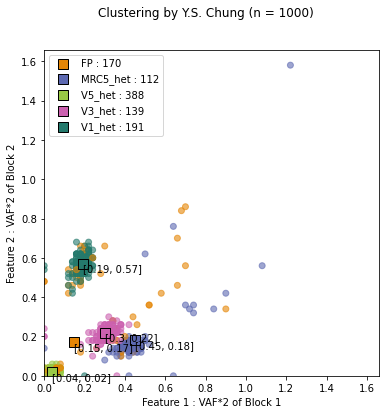

In [5]:
import palettable
vivid_10 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
colorlist = [i for i in vivid_10]

# Block 1, 2:  data point를 2차원 평면상에 그려보기
def drawfigure_2d(membership, owner, alpha):
    plt.figure (figsize = (6,6))
    plt.suptitle ("Clustering by {0} (n = {1})".format(owner, RANDOM_PICK))
    plt.axis ([0,  np.max(np_vaf[:,:]) * 2.1,  0,  np.max(np_vaf[:,:]) * 2.1])
    plt.xlabel ("Feature 1 : VAF*2 of Block 1")
    plt.ylabel ("Feature 2 : VAF*2 of Block 2")

    plt.scatter (np_vaf[:,0] * 2, np_vaf[:,1] * 2, alpha = 0.6 , color = [colorlist[samplename_dict[k]] for k in membership_answer])

    for sample_index, sample in enumerate(samplename_dict):
        if sample not in set(membership):
            continue
        x_mean = round(np.mean(np_vaf[[x  for x in range(len(membership)) if membership[x] == sample]][:,0] * 2), 2)
        y_mean = round(np.mean(np_vaf[[x  for x in range(len(membership)) if membership[x] == sample]][:,1] * 2), 2)

        print (sample, x_mean, y_mean)

        plt.text (x_mean, y_mean, "{0}".format([x_mean, y_mean]), verticalalignment = 'top')
        plt.scatter (x_mean, y_mean, marker = 's', color = colorlist[sample_index], edgecolor = 'black', s = 100, 
            label = sample +  " : " + str(list(membership).count(sample)))
        plt.legend()



# Block 1, 2, 3 : data point를 3차원 공간상에 그려보기

def drawfigure_3d(membership, owner, alpha):
    from mpl_toolkits import mplot3d
    

    fig = plt.figure (figsize = (10,10))
    plt.suptitle ("3D Clustering by {0} (n = {1})".format(owner, NUM_MUTATION))
    ax = plt.axes(projection ="3d")
    ax.grid(True)
    plt.rcParams['grid.linewidth'] = 0.1

    ax.set_xlabel ("Feature 1 : VAF*2 of Block 1")
    ax.set_ylabel ("Feature 2 : VAF*2 of Block 2")
    ax.set_zlabel ("Feature 3 : VAF*2 of Block 3")
    ax.set_xlim3d(0, np.max(np_vaf[:,:]) * 2.1,); ax.set_ylim3d(0, np.max(np_vaf[:,:]) * 2.1,); ax.set_zlim3d(0, np.max(np_vaf[:,:]) * 2.1,)
    ax.scatter3D (np_vaf[:,0] * 2, np_vaf[:,1] * 2, np_vaf[:,2] * 2, alpha = 0.8, s = 40, color = [colorlist[samplename_dict[k]] for k in membership])

    for sample_index, sample in enumerate(samplename_dict):
        x_mean = round(np.mean(np_vaf[[x  for x in range(len(membership)) if membership[x] == sample]][:,0] * 2), 2)
        y_mean = round(np.mean(np_vaf[[x  for x in range(len(membership)) if membership[x] == sample]][:,1] * 2), 2)
        z_mean = round(np.mean(np_vaf[[x  for x in range(len(membership)) if membership[x] == sample]][:,2] * 2), 2)

        print (sample, x_mean, y_mean, z_mean)

        ax.scatter3D (x_mean, y_mean, z_mean, marker = '8', color = colorlist[sample_index], edgecolor = 'black', s = 200, linewidth = 2,
            label = sample + " : " + str(list(membership).count(sample)) )
        ax.text (x_mean, y_mean, z_mean, "{0}".format([x_mean, y_mean, z_mean]), fontsize = 15)
        ax.legend()


if NUM_BLOCK == 2:
    drawfigure_2d(membership_answer, "Y.S. Chung", 0)
if NUM_BLOCK == 3:
    drawfigure_3d(membership_answer, "Y.S. Chung", 0)

# EM 돌려보기 (GERMLINE cluster 포함)

In [391]:
from collections import Counter
import scipy as sp
import scipy.stats
from scipy.special import beta, gamma
import math

NUM_BLOCK = 2
NUM_CLONE_TRIAL_START = 3
NUM_CLONE_TRIAL_END = 5

NUM_MUTATION = RANDOM_PICK
SEQ_ERROR = 0.01

gradient_max = float("-inf")
previous_maxmax_likelihood = 0
previous_maxmax_score = 0


# df : 2d list + dictionary  (k번째 mutation, i번째 block에서의 depth, ref, alt)
# mixture : 2d ndarray       (i번째 block에서 j번째 clone의 분율)
# membership : 1d ndarray    (k번째 mutation이 어떤 clone인지)


maxmaxmax_likelihood = float("-inf")    # 모든 NUM_CLONE에서 최대값을 갖는 것을 저장
maxmaxmax_membership = np.zeros (NUM_MUTATION, dtype = "int32") 
maxmaxmax_NUM_CLONE = 0

maxmaxmax_mixture_record = []
maxmaxmax_membership_record = []
maxmaxmax_likelihood_record = []
maxmaxmax_score_record = []



def initial_parameter(NUM_CLONE, trial):
    while True:
        for i in range (NUM_BLOCK):
            li = list(range(NUM_CLONE))   # 분율이 0인 경우도 포함
            choiceLIst = Counter([random.choice(li) for i in range(10)])
            
            for j in range (NUM_CLONE):
                mixture[i][j] = choiceLIst[j] / 10

            mixture[i][NUM_CLONE] = 1.0   #germline 용
        break
        # if 0 not in mixture:   # 처음부터 분율이 0인게 있으면 다시 돌려라
        #     break
      

    # print ("INITIAL : trial " + str(trial + 1) )
    # for i in range (NUM_BLOCK):
    #    print ("\t{0}".format(mixture[i]))

    return mixture


def calc_likelihood (mixture, k):
    global df

    max_prob = -99999; max_clone = -1


    for j in range (NUM_CLONE + 1):
        prob = 0; prob2 = 0
        for i in range (NUM_BLOCK):
            depth_calc = int(df[k][i]["depth"] * mixture[i][j])
            alt_calc = int(df[k][i]["depth"] * mixture[i][j] * 0.5)
            depth_obs = int(df[k][i]["depth"])
            alt_obs = int(df[k][i]["alt"])
            
            # Binomial probability
            # if depth_calc >= alt_obs:
            #     try:
            #         prob = prob + math.log10(scipy.stats.binom.pmf (n = depth_calc,k = alt_obs, p = 0.5))            # 이렇게 하면 안되고 beta binomial로 계산해야 함  ( Beta  (alt_expected, depth - alt_expected , vaf_observed))
            #     except:
            #         prob = prob - 400
            #     #math.log10(sys.float_info.min*sys.float_info.epsilon)
            # else :
            #     prob = prob +  math.log10(SEQ_ERROR) * (alt_obs-depth_calc)


            # Beta binomial distribution
            # a = df[k][i]["depth"] * mixture[i][j] * 0.5              # alt_expected
            # b = depth_obs - a            # ref_expected
            # x = round(alt_obs / depth_obs, 2)    # vaf_observed
            # if a < 1:
            #     a = 1
            # prob = prob + scipy.stats.beta.pdf(x, a, b)
            

            # # Beta binomial distribution
            a = df[k][i]["depth"] * mixture[i][j] * 0.5              # alt_expected
            b = depth_obs - a            # ref_expected
            try:
                prob = prob + math.log10(scipy.stats.betabinom.pmf(alt_obs, depth_obs, a+1, b+1))
            except:
                prob = prob - 400


            # print ("{0}번째 mutation : {1} 번째 clone, {2}번째 block → alt_expected : {3},  alt_observed : {4}, depth_observed : {5}, likelihood : {6}"\
            #         .format(k, j, i, round(a,1), alt_obs, depth_obs,  scipy.stats.betabinom.pmf(alt_obs, depth_obs, a+1, b+1) ))
                  
        if prob > max_prob:
            max_prob = prob
            max_prob_clone_candidate = [j]
        elif prob == max_prob:
            max_prob_clone_candidate.append(j)
    
    max_clone = random.choice(max_prob_clone_candidate)
    # print ("mutation_{0} : {1}번 clone이 가장 적절 (log p = {2})\n".format(k, max_clone, max_prob))
    return max_clone, max_prob


def Estep( mixture ):  ## MEMBERSHIP 정하는 과정
    total_prob = 0
    max_prob_list = []
    membership = np.zeros (NUM_MUTATION, dtype = "int32")

    for k in range (NUM_MUTATION):
        j, max_prob = calc_likelihood (mixture, k)  # k번째 mutation은 membership을 누구에게 주는 게 좋을까?
        membership[k] = j
        total_prob = total_prob + max_prob
        max_prob_list.append(max_prob)
        

    # print ("\tTotal likelihood : {0}".format(round(total_prob,2)))

    return round(total_prob,2), membership


def Mstep(membership):  ## 새로운 MIXTURE 정하는 과정
    mixture = np.zeros ((NUM_BLOCK, NUM_CLONE + 1), dtype = 'float')     #mixture 값을 일단 초기화


    for j in range (NUM_CLONE):       
        ind_list = []          # membership == j 인 index를 구하기
        for k in range(NUM_MUTATION):
            if membership[k] == j:
                ind_list.append(k)

        
        for i in range (NUM_BLOCK):
            sum_depth = 0; sum_alt = 0
            for ind in ind_list:       # depth, alt를 다 더하기
                sum_depth = sum_depth + df[ind][i]["depth"]
                sum_alt = sum_alt + df[ind][i]["alt"]
            
            #print (i, j, sum_depth, sum_alt)
            if sum_depth == 0:      # i번째 block에서 j번째 clone이 아예 없으면 0을 준다
                mixture[i][j] = 0
            else:                   # j번째 clone만을 생각한 이상적인 분율을 일단 assign
                mixture[i][j] = round((sum_alt * 2) / sum_depth,2)
           
     # Block당 Mixture의 합이 1이 되도록 재조정       
    for i in range (NUM_BLOCK):
        sum = 0
        for j in range (NUM_CLONE):
            sum = sum + mixture[i][j]
        mixture[i] = np.round(mixture[i] / sum, 2)

    for i in range(NUM_BLOCK):   # germline clustering 용으로 하나 채운다
        mixture[i][NUM_CLONE]  = 1.0

    return mixture


def Sorting ( membership, mixture):
    # membership, mixture를 앞에 나오는 순서대로 numbering을 다시 해줌
    mixture_sort = np.zeros ((NUM_BLOCK, NUM_CLONE + 1), dtype = 'float') 
    membership_sort = []
    dict={}
    num = 0

    # membership을 정렬해서 보내줌
    for k in range(NUM_MUTATION):
        if membership[k] not in dict:
            membership_sort.append (num)
            dict[membership[k]] = num
            num = num + 1
        else:
            membership_sort.append (dict[membership[k]])
    membership_sort = np.array(membership_sort)

    # 그 순서대로 mixture도 정렬해서 보내줌
    for i in range (0, NUM_BLOCK):
        for j in range (0, NUM_CLONE):
            if j in dict:
                mixture_sort[i][dict[j]] = mixture[i][j]
        mixture_sort[i][NUM_CLONE] = 1.0

    return membership_sort, mixture_sort


def GoStop(t, total_prob, membership, mixture, previous_No, previous_membership, previous_likelihood ): # 이전 membership과 겹치거나 likelihood가 나아질 기미가 보이지 않으면 stop

    global max_likelihood; global max_membership; global max_mixture; global NUM_MUTATION

    # 방금 step에서 구한게 최적값을 경신했는지 판다
    if total_prob > max_likelihood:
        #print ("\t\t\t\t !!!!!! Renewal : ", total_prob)
        max_likelihood = total_prob
        max_membership = membership
        max_mixture = mixture


    # 첫 5번 정도는 판단 유예
    if t >= previous_No:
        #print ("Concordance score : ", end = " " )
        for p in range(previous_No):       # 지난 5개의 membership을 보고 비교해본다
            #print (str(np.sum(np.equal(membership, previous_membership[p]))) + "점", end = "\t")
            if np.sum(np.equal(membership, previous_membership[p])) >= int(NUM_MUTATION * 0.9):          # membership이 90% 이상 겹치면 stop 해주자
                #print ("\n\n지난 {0} 번째와 membership 변화가 없어서 stop : {1}개 겹침".format(p, np.sum(np.equal(membership, previous_membership[p]))))
                return "Stop", previous_membership, previous_likelihood
        # if (total_prob) < 0.99 * np.max(previous_likelihood):
        #     print ("\n\nLikelihood 기준으로 stop")
        #     return "Stop", previous_membership, previous_likelihood


    # 차곡차곡 채워넣어준다
    previous_membership[t % previous_No] = membership
    previous_likelihood[t % previous_No] = total_prob


    return "Go", previous_membership, previous_likelihood



for NUM_CLONE in range (NUM_CLONE_TRIAL_START ,NUM_CLONE_TRIAL_END + 1 ):
    print ("NUM_CLONE = {0} + 1".format(NUM_CLONE))
    mixture = np.zeros ((NUM_BLOCK, NUM_CLONE + 1), dtype = 'float') 
    for i in range(NUM_BLOCK):   # germline clustering 용으로 하나 채운다
        mixture[i][NUM_CLONE]  = 1.0
    membership = np.zeros (NUM_MUTATION, dtype = "int32")

    previous_No = 5
    previous_membership = np.zeros ((previous_No, NUM_MUTATION), dtype = "int32")
    previous_likelihood = np.zeros (previous_No, dtype = 'float'); previous_likelihood.fill(float("-inf"))

    max_likelihood = float("-inf")          # 한 trial 내에서 최대값을 갖는 것을 저장
    max_membership = np.zeros (NUM_MUTATION, dtype = "int32")
    max_mixture = np.zeros ((NUM_BLOCK, NUM_CLONE + 1), dtype = 'float') 

    maxmax_likelihood = float("-inf")       # 한 NUM_CLONE에서 최대값을 갖는 것을 저장
    maxmax_membership = np.zeros (NUM_MUTATION, dtype = "int32")
    maxmax_mixture = np.zeros ((NUM_BLOCK, NUM_CLONE + 1), dtype = 'float') 

    mixture_record = []
    membership_record = []
    likelihood_record = []



    for trial in range(10):
        mixture = initial_parameter(NUM_CLONE, trial)
        max_mixture = mixture
        max_likelihood = float("-inf")
        max_membership = np.zeros (NUM_MUTATION, dtype = "int32")

        # mixture = np.array([[0.3,0.6,0.1],[0.7,0.1,0.2]])

        for t in range(1,30):
            #print ("\n\n #{0}번째 step\n".format(t))


            total_prob, membership = Estep( mixture )            # 주어진 mixture 내에서 새 membership 정하기
            mixture = Mstep(membership)        # 새 memberhsip에서 새 mixture구하기
            membership_sort, mixture_sort = Sorting ( membership, mixture)
        
            #print ("E-step >\n\tTotal prob : {0} \t  membership : {1} ".format(total_prob, membership_sort))
            #print ("M-step >\n{0}". format(mixture_sort))

            message, previous_membership, previous_likelihood = GoStop(t, total_prob, membership_sort, mixture_sort, previous_No, previous_membership, previous_likelihood)
            if message == "Stop":
                break
            
            #print ("지금 step까지 max likelihood : {0}\n지금 step까지 max_membership : {1}".format(max_likelihood, max_membership))


        check = 0
        for j in range(NUM_CLONE):
            if j not in np.unique(max_membership):
                check = 1
        if check == 1:   # 설정한 NUM_CLONE과 정답의 NUM_CLONE 개수가 맞지 않으면 넘어가자
            continue

        #print ("이번 trial의 Total Likelihood = {0}\n{1}".format(max_likelihood, max_membership))
        #print (max_mixture,"\n")

        if maxmax_likelihood < max_likelihood:
            maxmax_likelihood = max_likelihood
            maxmax_mixture = max_mixture
            maxmax_membership = max_membership


    print ("NUM_CLONE = {0} : {1}\n{2}\n\n".format(NUM_CLONE,maxmax_likelihood, maxmax_mixture))
    print (likelihood_record)
    
    maxmaxmax_likelihood_record.append (maxmax_likelihood)
    maxmaxmax_mixture_record.append (maxmax_mixture)
    maxmaxmax_membership_record.append (maxmax_membership)

    if gradient_max < maxmax_likelihood - previous_maxmax_likelihood:   # Elbow 법을 적용하기 위한 gadient 값 도입
        gradient_max = maxmax_likelihood - previous_maxmax_likelihood
        previous_maxmax_likelihood = maxmax_likelihood
        maxmaxmax_likelihood = maxmax_likelihood
        maxmaxmax_mixture = maxmax_mixture
        maxmaxmax_membership = maxmax_membership
        maxmaxmax_NUM_CLONE = NUM_CLONE
        #maxmaxmax_score_record_record = score_record
        maxmaxmax_likelihood_record_record = likelihood_record

        
print ("최종 정답\n\tclone={0}\n{1}".format(maxmaxmax_NUM_CLONE, maxmaxmax_membership))


NUM_CLONE = 3 + 1
NUM_CLONE = 3 : -5295.24
[[0.05 0.33 0.62 1.  ]
 [0.03 0.34 0.63 1.  ]]


[]
NUM_CLONE = 4 + 1
NUM_CLONE = 4 : -2496.73
[[0.04 0.44 0.21 0.   1.  ]
 [0.02 0.18 0.59 0.   1.  ]]


[]
NUM_CLONE = 5 + 1
NUM_CLONE = 5 : -2363.77
[[0.04 0.43 0.2  0.   0.04 1.  ]
 [0.03 0.16 0.58 0.   0.01 1.  ]]


[]
최종 정답
	clone=4
[0 1 2 3 2 0 0 4 4 2 0 0 1 0 0 1 0 2 0 0 0 2 0 2 0 2 1 4 0 4 0 1 2 2 0 4 0
 0 0 0 0 0 0 2 2 0 4 0 4 0 0 4 1 2 0 2 0 0 4 1 2 4 0 0 0 4 0 1 2 2 2 0 0 0
 4 4 4 2 1 0 0 2 0 4 0 0 0 4 1 0 0 0 1 2 0 4 0 0 0 0 4 2 0 4 0 0 0 0 2 2 2
 0 0 0 2 0 0 4 1 0 0 0 2 0 2 0 2 1 2 4 0 0 0 4 0 1 1 0 0 0 0 4 2 2 0 0 3 0
 0 0 0 0 0 2 0 4 0 4 0 0 0 4 0 4 2 1 1 1 4 2 0 2 4 2 4 2 1 2 4 2 2 0 4 2 2
 0 0 0 0 4 0 0 0 2 0 0 1 0 0 2 0 2 0 0 4 4 2 2 0 0 1 0 0 0 0 2 0 2 1 1 2 1
 2 2 0 0 0 2 2 2 0 2 0 0 0 0 0 2 0 4 0 4 2 0 0 1 4 4 0 0 0 0 4 2 0 0 0 0 2
 0 0 4 4 0 4 0 0 2 4 0 2 0 0 0 0 1 4 0 4 1 1 0 0 0 0 4 2 0 0 4 1 0 0 2 4 0
 2 2 2 0 2 4 4 4 4 0 0 4 4 2 4 2 2 0 4 2 0 0 2 2 0 1 4 1 0 4 0 2 2 4 0

# EM 돌려보기 2.  (먼 거리는 제외)

In [6]:
from collections import Counter
import scipy as sp
import scipy.stats
from scipy.special import beta, gamma
import math

NUM_BLOCK = 2
NUM_CLONE_TRIAL_START = 3
NUM_CLONE_TRIAL_END = 9

NUM_MUTATION = RANDOM_PICK
SEQ_ERROR = 0.01

gradient_max = float("-inf")
previous_maxmax_likelihood = 0
previous_maxmax_score = 0


# df : 2d list + dictionary  (k번째 mutation, i번째 block에서의 depth, ref, alt)
# mixture : 2d ndarray       (i번째 block에서 j번째 clone의 분율)
# membership : 1d ndarray    (k번째 mutation이 어떤 clone인지)


maxmaxmax_likelihood = float("-inf")    # 모든 NUM_CLONE에서 최대값을 갖는 것을 저장
maxmaxmax_membership = np.zeros (NUM_MUTATION, dtype = "int32") 
maxmaxmax_NUM_CLONE = 0

maxmaxmax_mixture_record = []
maxmaxmax_membership_record = []
maxmaxmax_likelihood_record = []
maxmaxmax_score_record = []



def initial_parameter(NUM_CLONE, trial):
    while True:
        for i in range (NUM_BLOCK):
            li = list(range(NUM_CLONE))   # 분율이 0인 경우도 포함
            choiceLIst = Counter([random.choice(li) for i in range(10)])
            
            for j in range (NUM_CLONE):
                mixture[i][j] = choiceLIst[j] / 10

        break
        # if 0 not in mixture:   # 처음부터 분율이 0인게 있으면 다시 돌려라
        #     break
      

    # print ("INITIAL : trial " + str(trial + 1) )
    # for i in range (NUM_BLOCK):
    #    print ("\t{0}".format(mixture[i]))

    return mixture


def calc_likelihood (mixture, k, NUM_CLONE, NUM_BLOCK):
    global df

    max_prob = -99999; max_clone = -1


    for j in range (NUM_CLONE):
        prob = 0; prob2 = 0
        for i in range (NUM_BLOCK):
            depth_calc = int(df[k][i]["depth"] * mixture[i][j])
            alt_calc = int(df[k][i]["depth"] * mixture[i][j] * 0.5)
            depth_obs = int(df[k][i]["depth"])
            alt_obs = int(df[k][i]["alt"])
            
            # Binomial probability
            # if depth_calc >= alt_obs:
            #     try:
            #         prob = prob + math.log10(scipy.stats.binom.pmf (n = depth_calc,k = alt_obs, p = 0.5))            # 이렇게 하면 안되고 beta binomial로 계산해야 함  ( Beta  (alt_expected, depth - alt_expected , vaf_observed))
            #     except:
            #         prob = prob - 400
            #     #math.log10(sys.float_info.min*sys.float_info.epsilon)
            # else :
            #     prob = prob +  math.log10(SEQ_ERROR) * (alt_obs-depth_calc)


            # Beta binomial distribution
            # a = df[k][i]["depth"] * mixture[i][j] * 0.5              # alt_expected
            # b = depth_obs - a            # ref_expected
            # x = round(alt_obs / depth_obs, 2)    # vaf_observed
            # if a < 1:
            #     a = 1
            # prob = prob + scipy.stats.beta.pdf(x, a, b)
            

            # # Beta binomial distribution
            a = df[k][i]["depth"] * mixture[i][j] * 0.5              # alt_expected
            b = depth_obs - a            # ref_expected
            try:
                prob = prob + math.log10(scipy.stats.betabinom.pmf(alt_obs, depth_obs, a+1, b+1))
            except:
                prob = prob - 400


            # print ("{0}번째 mutation : {1} 번째 clone, {2}번째 block → alt_expected : {3},  alt_observed : {4}, depth_observed : {5}, likelihood : {6}"\
            #         .format(k, j, i, round(a,1), alt_obs, depth_obs,  scipy.stats.betabinom.pmf(alt_obs, depth_obs, a+1, b+1) ))
                  
        if prob > max_prob:
            max_prob = prob
            max_prob_clone_candidate = [j]
        elif prob == max_prob:
            max_prob_clone_candidate.append(j)
    
    max_clone = random.choice(max_prob_clone_candidate)
    # print ("mutation_{0} : {1}번 clone이 가장 적절 (log p = {2})\n".format(k, max_clone, max_prob))
    return max_clone, max_prob


def Estep( mixture , NUM_CLONE, NUM_BLOCK):  ## MEMBERSHIP 정하는 과정
    total_prob = 0
    max_prob_list = []
    membership = np.zeros (NUM_MUTATION, dtype = "int32")

    for k in range (NUM_MUTATION):
        j, max_prob = calc_likelihood (mixture, k, NUM_CLONE, NUM_BLOCK)  # k번째 mutation은 membership을 누구에게 주는 게 좋을까?
        membership[k] = j
        total_prob = total_prob + max_prob
        max_prob_list.append(max_prob)
        

    # print ("\tTotal likelihood : {0}".format(round(total_prob,2)))

    return round(total_prob,2), membership


def Mstep(membership, NUM_CLONE, NUM_BLOCK):  ## 새로운 MIXTURE 정하는 과정
    mixture = np.zeros ((NUM_BLOCK, NUM_CLONE), dtype = 'float')     #mixture 값을 일단 초기화


    for j in range (NUM_CLONE):       
        ind_list = []          # membership == j 인 index를 구하기
        for k in range(NUM_MUTATION):
            if membership[k] == j:
                ind_list.append(k)

        
        for i in range (NUM_BLOCK):
            sum_depth = 0; sum_alt = 0
            for ind in ind_list:       # depth, alt를 다 더하기
                sum_depth = sum_depth + df[ind][i]["depth"]
                sum_alt = sum_alt + df[ind][i]["alt"]
            
            #print (i, j, sum_depth, sum_alt)
            if sum_depth == 0:      # i번째 block에서 j번째 clone이 아예 없으면 0을 준다
                mixture[i][j] = 0
            else:                   # j번째 clone만을 생각한 이상적인 분율을 일단 assign
                mixture[i][j] = round((sum_alt * 2) / sum_depth,2)
           
     # Block당 Mixture의 합이 1이 되도록 재조정       
    for i in range (NUM_BLOCK):
        sum = 0
        for j in range (NUM_CLONE):
            sum = sum + mixture[i][j]
        mixture[i] = np.round(mixture[i] / sum, 2)

    return mixture


def Sorting ( membership, mixture):
    # membership, mixture를 앞에 나오는 순서대로 numbering을 다시 해줌
    mixture_sort = np.zeros ((NUM_BLOCK, NUM_CLONE ), dtype = 'float') 
    membership_sort = []
    dict={}
    num = 0

    # membership을 정렬해서 보내줌
    for k in range(NUM_MUTATION):
        if membership[k] not in dict:
            membership_sort.append (num)
            dict[membership[k]] = num
            num = num + 1
        else:
            membership_sort.append (dict[membership[k]])
    membership_sort = np.array(membership_sort)

    # 그 순서대로 mixture도 정렬해서 보내줌
    for i in range (0, NUM_BLOCK):
        for j in range (0, NUM_CLONE):
            if j in dict:
                mixture_sort[i][dict[j]] = mixture[i][j]

    return membership_sort, mixture_sort


def GoStop(t, total_prob, membership, mixture, previous_No, previous_membership, previous_likelihood ): # 이전 membership과 겹치거나 likelihood가 나아질 기미가 보이지 않으면 stop

    global max_likelihood; global max_membership; global max_mixture; global NUM_MUTATION

    # 방금 step에서 구한게 최적값을 경신했는지 판다
    if total_prob > max_likelihood:
        #print ("\t\t\t\t !!!!!! Renewal : ", total_prob)
        max_likelihood = total_prob
        max_membership = membership
        max_mixture = mixture


    # 첫 5번 정도는 판단 유예
    if t >= previous_No:
        #print ("Concordance score : ", end = " " )
        for p in range(previous_No):       # 지난 5개의 membership을 보고 비교해본다
            #print (str(np.sum(np.equal(membership, previous_membership[p]))) + "점", end = "\t")
            if np.sum(np.equal(membership, previous_membership[p])) >= int(NUM_MUTATION * 0.9):          # membership이 90% 이상 겹치면 stop 해주자
                #print ("\n\n지난 {0} 번째와 membership 변화가 없어서 stop : {1}개 겹침".format(p, np.sum(np.equal(membership, previous_membership[p]))))
                return "Stop", previous_membership, previous_likelihood
        # if (total_prob) < 0.99 * np.max(previous_likelihood):
        #     print ("\n\nLikelihood 기준으로 stop")
        #     return "Stop", previous_membership, previous_likelihood


    # 차곡차곡 채워넣어준다
    previous_membership[t % previous_No] = membership
    previous_likelihood[t % previous_No] = total_prob


    return "Go", previous_membership, previous_likelihood



for NUM_CLONE in range (NUM_CLONE_TRIAL_START ,NUM_CLONE_TRIAL_END + 1 ):
    print ("NUM_CLONE = {0}".format(NUM_CLONE))
    mixture = np.zeros ((NUM_BLOCK, NUM_CLONE), dtype = 'float') 
    membership = np.zeros (NUM_MUTATION, dtype = "int32")

    previous_No = 5
    previous_membership = np.zeros ((previous_No, NUM_MUTATION), dtype = "int32")
    previous_likelihood = np.zeros (previous_No, dtype = 'float'); previous_likelihood.fill(float("-inf"))

    max_likelihood = float("-inf")          # 한 trial 내에서 최대값을 갖는 것을 저장
    max_membership = np.zeros (NUM_MUTATION, dtype = "int32")
    max_mixture = np.zeros ((NUM_BLOCK, NUM_CLONE + 1), dtype = 'float') 

    maxmax_likelihood = float("-inf")       # 한 NUM_CLONE에서 최대값을 갖는 것을 저장
    maxmax_membership = np.zeros (NUM_MUTATION, dtype = "int32")
    maxmax_mixture = np.zeros ((NUM_BLOCK, NUM_CLONE + 1), dtype = 'float') 

    mixture_record = []
    membership_record = []
    likelihood_record = []



    for trial in range(5):
        mixture = initial_parameter(NUM_CLONE, trial)
        max_mixture = mixture
        max_likelihood = float("-inf")
        max_membership = np.zeros (NUM_MUTATION, dtype = "int32")

        # mixture = np.array([[0.3,0.6,0.1],[0.7,0.1,0.2]])

        for t in range(1,30):
            #print ("\n\n #{0}번째 step\n".format(t))


            total_prob, membership = Estep( mixture, NUM_CLONE, NUM_BLOCK )            # 주어진 mixture 내에서 새 membership 정하기
            mixture = Mstep(membership , NUM_CLONE, NUM_BLOCK)        # 새 memberhsip에서 새 mixture구하기
            membership_sort, mixture_sort = Sorting ( membership, mixture)
        
            #print ("E-step >\n\tTotal prob : {0} \t  membership : {1} ".format(total_prob, membership_sort))
            #print ("M-step >\n{0}". format(mixture_sort))

            message, previous_membership, previous_likelihood = GoStop(t, total_prob, membership_sort, mixture_sort, previous_No, previous_membership, previous_likelihood)
            if message == "Stop":
                break
            
            #print ("지금 step까지 max likelihood : {0}\n지금 step까지 max_membership : {1}".format(max_likelihood, max_membership))


        check = 0
        for j in range(NUM_CLONE):
            if j not in np.unique(max_membership):
                check = 1
        if check == 1:   # 설정한 NUM_CLONE과 정답의 NUM_CLONE 개수가 맞지 않으면 넘어가자
            continue

        #print ("이번 trial의 Total Likelihood = {0}\n{1}".format(max_likelihood, max_membership))
        #print (max_mixture,"\n")

        if maxmax_likelihood < max_likelihood:
            maxmax_likelihood = max_likelihood
            maxmax_mixture = max_mixture
            maxmax_membership = max_membership


    print ("NUM_CLONE = {0} : {1}\n{2}\n\n".format(NUM_CLONE,maxmax_likelihood, maxmax_mixture))
    print (likelihood_record)
    
    maxmaxmax_likelihood_record.append (maxmax_likelihood)
    maxmaxmax_mixture_record.append (maxmax_mixture)
    maxmaxmax_membership_record.append (maxmax_membership)

    #if gradient_max < maxmax_likelihood - previous_maxmax_likelihood:   # Elbow 법을 적용하기 위한 gadient 값 도입
    if maxmaxmax_likelihood < maxmax_likelihood :   # 최고의 값만 구하고 싶을 때
        gradient_max = maxmax_likelihood - previous_maxmax_likelihood
        previous_maxmax_likelihood = maxmax_likelihood
        maxmaxmax_likelihood = maxmax_likelihood
        maxmaxmax_mixture = maxmax_mixture
        maxmaxmax_membership = maxmax_membership
        maxmaxmax_NUM_CLONE = NUM_CLONE
        #maxmaxmax_score_record_record = score_record
        maxmaxmax_likelihood_record_record = likelihood_record

        
print ("최종 정답\n\tclone={0}\n{1}".format(maxmaxmax_NUM_CLONE, maxmaxmax_membership))


NUM_CLONE = 3
NUM_CLONE = 3 : -11543.12
[[0.08 0.32 0.6 ]
 [0.04 0.71 0.25]]


[]
NUM_CLONE = 4
NUM_CLONE = 4 : -5020.26
[[0.04 0.2  0.46 0.31]
 [0.02 0.59 0.18 0.22]]


[]
NUM_CLONE = 5
NUM_CLONE = 5 : -4887.27
[[0.02 0.05 0.19 0.44 0.3 ]
 [0.03 0.02 0.56 0.17 0.22]]


[]
NUM_CLONE = 6
NUM_CLONE = 6 : -5292.93
[[0.04 0.04 0.19 0.43 0.3  0.  ]
 [0.01 0.01 0.43 0.13 0.16 0.26]]


[]
NUM_CLONE = 7
NUM_CLONE = 7 : -4725.76
[[0.05 0.19 0.35 0.04 0.01 0.37 0.  ]
 [0.03 0.49 0.17 0.   0.02 0.   0.3 ]]


[]
NUM_CLONE = 8
NUM_CLONE = 8 : -5504.69
[[0.05 0.19 0.4  0.05 0.28 0.01 0.03 0.  ]
 [0.02 0.42 0.13 0.   0.15 0.01 0.01 0.26]]


[]
NUM_CLONE = 9


### 채점하기
- 뭔가 좀더 좋은 방법이 있을 것 같은데... 어떻게 잘 짜지?

In [56]:


membership_answer_num, mixture_null = Sorting(membership_answer, np.zeros ((NUM_BLOCK, NUM_CLONE), dtype = 'float') )


def Scoring (answer_membership, my_membership):
    import itertools
    max_score = 0
    max = []

    p = int(np.max(answer_membership))

    for tt in list(itertools.permutations( list(range(0, p + 1)),  p + 1 ) ):
        index_dict = {}
        for i in range(0, p + 1):
            index_dict[i] = tt[i]

        # 정답 membership을 돌려보기
        temp = []
        for i in range(len(answer_membership)):
            temp.append( index_dict[ answer_membership [i] ] )
        
        # maxmaxmax_membership과의 일치도 확인
        if np.sum(np.equal(temp, my_membership)) > max_score:
            max_score = np.sum(np.equal(temp, my_membership))
            max = temp

    return  max, round((max_score / len(answer_membership) * 100) , 2)

membership_answer_max, score = Scoring (membership_answer_num, maxmaxmax_membership)

print (str(score) + " 점")



sample_dict_rev={}
for i in range(len(membership_answer_max)):
    sample_dict_rev[membership_answer_max[i]] = membership_answer[i]    # {3: 'MRC5_het', 4: 'FP', 0: 'V3_het', 1: 'V5_het', 2: 'V1_het'}
print(sample_dict_rev)

    

81.2 점
{4: 'FP', 3: 'MRC5_het', 0: 'V5_het', 2: 'V1_het', 1: 'V3_het'}


### EM results를 기반으로 visualization 하기

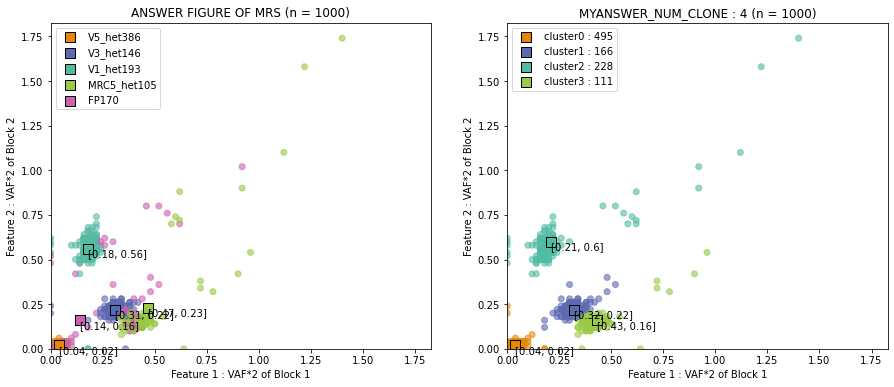

In [57]:
# Block 1, 2:  data point를 2차원 평면상에 그려보기
def drawfigure_2d(membership_answer_max, maxmaxmax_membership):
    fig, ax = plt.subplots(ncols = 2, figsize = (15,6)) 

    ax[0].set_title ("ANSWER FIGURE OF MRS (n = {0})".format(RANDOM_PICK))
    ax[1].set_title ("MYANSWER_NUM_CLONE : {0} (n = {1})".format(maxmaxmax_NUM_CLONE, RANDOM_PICK))
    ax[0].axis ([0,  np.max(np_vaf[:,:]) * 2.1,  0,  np.max(np_vaf[:,:]) * 2.1])
    ax[1].axis ([0,  np.max(np_vaf[:,:]) * 2.1,  0,  np.max(np_vaf[:,:]) * 2.1])

    ax[0].scatter (np_vaf[:,0] * 2, np_vaf[:,1] * 2, alpha = 0.6 , color = [colorlist[k] for k in membership_answer_max])
    ax[1].scatter (np_vaf[:,0] * 2, np_vaf[:,1] * 2, alpha = 0.6 , color = [colorlist[k] for k in maxmaxmax_membership])

    ax[0].set_xlabel ("Feature 1 : VAF*2 of Block 1");  ax[1].set_xlabel ("Feature 1 : VAF*2 of Block 1")
    ax[0].set_ylabel ("Feature 2 : VAF*2 of Block 2"); ax[1].set_ylabel ("Feature 2 : VAF*2 of Block 2")

    # for sample_index, sample in enumerate(samplename_dict):
    #     if sample not in set(membership_answer):
    #         continue
    #     x_mean = round(np.mean(np_vaf[[x  for x in range(len(membership_answer)) if membership_answer[x] == sample]][:,0] * 2), 2)
    #     y_mean = round(np.mean(np_vaf[[x  for x in range(len(membership_answer)) if membership_answer[x] == sample]][:,1] * 2), 2)

    #     ax[0].text (x_mean, y_mean, "{0}".format([x_mean, y_mean]), verticalalignment = 'top')
    #     ax[0].scatter (x_mean, y_mean, marker = 's', color = colorlist[sample_index], edgecolor = 'black', s = 100, 
    #         label = sample +  " : " + str(list(membership_answer).count(sample)))
    #     ax[0].legend()

        
    for sample_index in range( int(np.max(membership_answer_max))  + 1  ):
        x_mean = round(np.mean(np_vaf[[x  for x in range(len(membership_answer_max)) if membership_answer_max[x] == sample_index]][:,0] * 2), 2)
        y_mean = round(np.mean(np_vaf[[x  for x in range(len(membership_answer_max)) if membership_answer_max[x] == sample_index]][:,1] * 2), 2)

        ax[0].text (x_mean, y_mean, "{0}".format([x_mean, y_mean]), verticalalignment = 'top')
        ax[0].scatter (x_mean, y_mean, marker = 's', color = colorlist[sample_index], edgecolor = 'black', s = 100, 
            label = sample_dict_rev[sample_index] + str(list(membership_answer_max).count(sample_index)))
        ax[0].legend()


    for sample_index in range(maxmaxmax_NUM_CLONE):
        x_mean = maxmaxmax_mixture[0][sample_index]
        y_mean = maxmaxmax_mixture[1][sample_index]

        ax[1].text (x_mean, y_mean, "{0}".format([x_mean, y_mean]), verticalalignment = 'top')
        ax[1].scatter (x_mean, y_mean, marker = 's', color = colorlist[sample_index], edgecolor = 'black', s = 100, 
            label = "cluster" + str(sample_index) +  " : " + str(list(maxmaxmax_membership).count(sample_index)))
        ax[1].legend()



# Block 1, 2, 3 : data point를 3차원 공간상에 그려보기

def drawfigure_3d(membership, owner, alpha):
    from mpl_toolkits import mplot3d
    

    fig = plt.figure (figsize = (10,10))
    plt.suptitle ("3D Clustering by {0} (n = {1})".format(owner, NUM_MUTATION))
    ax = plt.axes(projection ="3d")
    ax.grid(True)
    plt.rcParams['grid.linewidth'] = 0.1

    ax.set_xlabel ("Feature 1 : VAF*2 of Block 1")
    ax.set_ylabel ("Feature 2 : VAF*2 of Block 2")
    ax.set_zlabel ("Feature 3 : VAF*2 of Block 3")
    ax.set_xlim3d(0, np.max(np_vaf[:,:]) * 2.1,); ax.set_ylim3d(0, np.max(np_vaf[:,:]) * 2.1,); ax.set_zlim3d(0, np.max(np_vaf[:,:]) * 2.1,)
    ax.scatter3D (np_vaf[:,0] * 2, np_vaf[:,1] * 2, np_vaf[:,2] * 2, alpha = 0.8, s = 40, color = [colorlist[samplename_dict[k]] for k in membership])

    for sample_index in range(maxmaxmax_NUM_CLONE):
        x_mean = round(np.mean(np_vaf[[x  for x in range(len(membership)) if membership[x] == sample_index]][:,0] * 2), 2)
        y_mean = round(np.mean(np_vaf[[x  for x in range(len(membership)) if membership[x] == sample_index]][:,1] * 2), 2)
        z_mean = round(np.mean(np_vaf[[x  for x in range(len(membership)) if membership[x] == sample_index]][:,2] * 2), 2)

        print ("cluster" + str(sample_index+1), x_mean, y_mean, z_mean)

        ax.scatter3D (x_mean, y_mean, z_mean, marker = '8', color = colorlist[sample_index], edgecolor = 'black', s = 200, linewidth = 2,
            label ="cluster" + str(sample_index+1)  + " : " + str(list(membership).count(sample_index)) )
        ax.text (x_mean, y_mean, z_mean, "{0}".format([x_mean, y_mean, z_mean]), fontsize = 15)
        ax.legend()


if NUM_BLOCK == 2:
    drawfigure_2d(membership_answer_max, maxmaxmax_membership)
if NUM_BLOCK == 3:
    drawfigure_3d(maxmaxmax_membership)


cluster 0 : [135, 198, 354, 392, 418, 582, 980, 981, 982, 984, 985, 986, 987, 989, 990, 992, 993, 995, 996, 997, 998, 999]
cluster 1 : [11, 207, 215, 217, 311, 876, 890, 957, 963, 965]
cluster 2 : [155, 200, 202, 205, 226, 237, 405, 470, 506, 605, 656, 698, 847, 881, 897, 973, 974, 975, 977, 978, 983]
cluster 3 : [18, 169, 193, 234, 286, 517, 793, 934]
[135, 198, 354, 392, 418, 582, 980, 981, 982, 984, 985, 986, 987, 989, 990, 992, 993, 995, 996, 997, 998, 999, 11, 207, 215, 217, 311, 876, 890, 957, 963, 965, 155, 200, 202, 205, 226, 237, 405, 470, 506, 605, 656, 698, 847, 881, 897, 973, 974, 975, 977, 978, 983, 18, 169, 193, 234, 286, 517, 793, 934]
81.6점


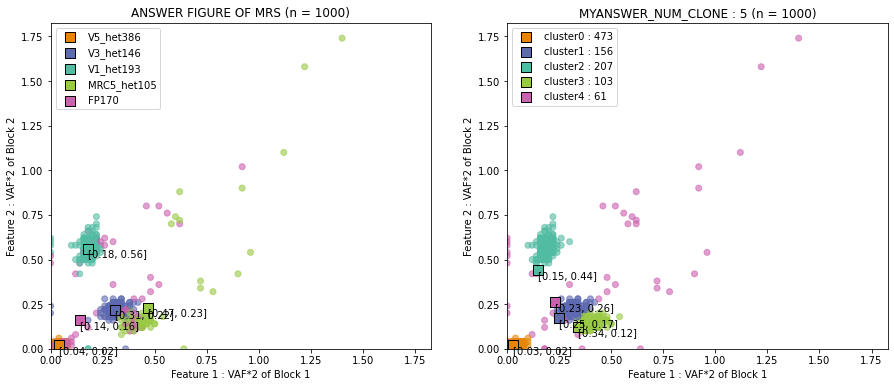

In [58]:
def Outlier_detection (prob_list):
    Q1 = np.percentile(prob_list, 25,  interpolation = 'midpoint')
    Q3 = np.percentile(prob_list, 75,  interpolation = 'midpoint')
    IQR = Q3 - Q1
    
    # Upper bound
    upper = list( np.where(prob_list>= (Q3+3*IQR)) [0])
    # Lower bound
    lower = list( np.where(prob_list<= (Q1-3*IQR)) [0])

    return upper + lower, (Q1-3*IQR),  (Q3+3*IQR)


def Estep_final ( maxmaxmax_mixture , maxmaxmax_membership, j ):  ## MEMBERSHIP 정하는 과정
    total_prob = 0
    max_prob_list = []
    membership = np.zeros (NUM_MUTATION, dtype = "int32")

    prob_list = []
    prob_list_index = []
    for k in range (NUM_MUTATION):
        if maxmaxmax_membership[k] != j:
            continue


        prob = 0
        for i in range (NUM_BLOCK):
            # # Beta binomial distribution
            depth_obs = int(df[k][i]["depth"])
            alt_obs = int(df[k][i]["alt"])
            a = df[k][i]["depth"] * maxmaxmax_mixture[i][j] * 0.5              # alt_expected
            b = depth_obs - a            # ref_expected
            try:
                prob = prob + math.log10(scipy.stats.betabinom.pmf(alt_obs, depth_obs, a+1, b+1))
            except:
                prob = prob - 400
            
        prob_list.append(prob)
        prob_list_index.append(k)

    
        # print ("{0}번째 mutation (block1 : {1},  block2 : {2})의 p → {3}    (alt_obs = {4}, alt_exp = {5}, depth = {6})" \
        #     .format(k, np_vaf[k][0] * 2, np_vaf[k][1] * 2, round(prob,2), alt_obs, a, depth_obs))        
    fp_candidate_prob_list, lowerbound, upperbound = Outlier_detection (prob_list)
    fp_candidate_index = [prob_list_index[i] for i in fp_candidate_prob_list]

    return fp_candidate_index



fp_candidate_index_total = []
for j in range(maxmaxmax_NUM_CLONE):       # 각 cluster마다 돌면서 outlier 찾아보기
    fp_candidate_index = Estep_final ( maxmaxmax_mixture, maxmaxmax_membership, j )            # outlier 구하러 떠나가자
    fp_candidate_index_total = fp_candidate_index_total  + fp_candidate_index
    print ("cluster {0} : {1}".format(j, fp_candidate_index))

print (fp_candidate_index_total)
for i in fp_candidate_index_total:
    maxmaxmax_membership[i] = maxmaxmax_NUM_CLONE
maxmaxmax_NUM_CLONE = maxmaxmax_NUM_CLONE + 1


# 새로 mixture를 정해준다
maxmaxmax_mixture = Mstep(maxmaxmax_membership , maxmaxmax_NUM_CLONE, NUM_BLOCK) 

# 그림 그려주기
if NUM_BLOCK == 2:
    drawfigure_2d(membership_answer_max, maxmaxmax_membership)


# 채점해주기
print (str (np.sum(np.equal(membership_answer_max, maxmaxmax_membership)) / len(membership_answer_num) * 100) + "점")

In [434]:
sample_dict_rev

{4: 'FP', 3: 'MRC5_het', 0: 'V5_het', 1: 'V1_het', 2: 'V3_het'}